<a href="https://colab.research.google.com/github/srilavanyasubramanian/srilavanyasubramanian/blob/main/GANexer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install tensorflow
import tensorflow  as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import  time
from IPython import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 749.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [29]:
(train_images,train_labels),(_, _) = tf.keras.datasets.mnist.load_data()

In [30]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5)/127.5

In [13]:
BUFFER_SIzE = 60000
BATCH_SIZE = 256

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIzE).batch(BATCH_SIZE)


In [15]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7,7,256)

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias = False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias = False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias = False,activation='tanh'))
  assert model.output_shape == (None,28,28,1)

  return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


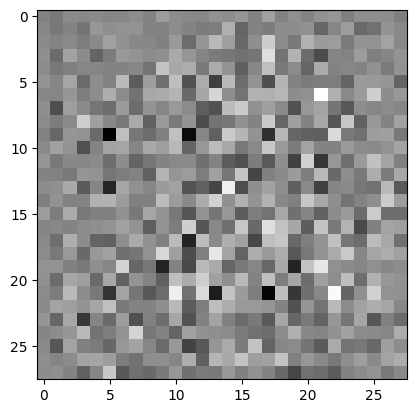

In [16]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0, :, :, 0],cmap='gray' )


In [17]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model



In [18]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00026642]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [20]:
def discriminator_loss(real_output,fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [21]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)


In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
check_point_dir = './training_checkpoints'
check_point_prefix = os.path.join(check_point_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator= generator,
                                 discriminator = discriminator)

In [24]:
Epochs = 50
nose_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate,nose_dim])

In [25]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,nose_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise,training=True)
    real_output = discriminator(images,training=True)
    fake_output = discriminator(generated_images,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output,fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))




In [26]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

      display.clear_output(wait=True)
      generate_and_save_images(generator,epoch + 1,seed)

      if(epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = check_point_prefix)
        print('Time for epoch {} is {} sec'.format(epoch + 1,time.time()-start))

        display.clear_output(wait=True)
        generate_and_save_images(generator,epochs,seed)


In [31]:
def generate_and_save_images(model,epoch,test_input):
  predictions = model(test_input,training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5,cmap = 'gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

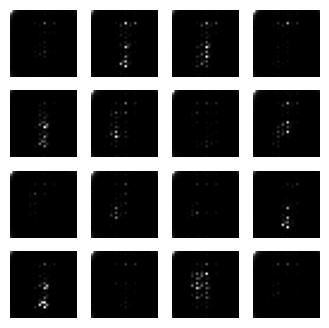

In [ ]:
train(train_dataset,Epochs)

In [6]:
checkpoint.restore(tf.train.latest_checkpoint(check_point_dir))

NameError: name 'checkpoint' is not defined

In [ ]:
def display_image(epoch_no):
  return PIL.Image.Open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file,mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)

  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)